# Imports

In [1]:
import jax 
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
px = 1/plt.rcParams["figure.dpi"]

import os

# set how much memory in your local CPU/GPU will be pre-allocated for JAX
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".75"

import optax

# Data Preprocessing

In [4]:
# MNIST dataset, already flat and normalized
X_train_1 = jnp.load('../mnist_np/X_train_1.npy') 
X_train_2 = jnp.load('../mnist_np/X_train_2.npy') 
X_train_3 = jnp.load('../mnist_np/X_train_3.npy') 
X_train_4 = jnp.load('../mnist_np/X_train_4.npy') 
# create X_train out of 4 X_trains
X_train = jnp.concatenate([X_train_1, X_train_2, X_train_3, X_train_4], axis=0)
y_train = jnp.load('../mnist_np/y_train.npy')
X_test = jnp.load('../mnist_np/X_test.npy')
y_test = jnp.load('../mnist_np/y_test.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000,) (10000, 784) (10000,)


In [5]:
def rate_encoding(key, X, sim_len=100):
    
    def bernoulli_encoding(key, spike_trains, sim_len):
        key, subkey = jax.random.split(key)
        return key, jax.random.bernoulli(key, spike_trains, (sim_len, spike_trains.shape[0], spike_trains.shape[1]))
    
    print('Encoding the data in batches of 2000 (going above take more time)')
    X_encoded = []
    batch_size = 2000
    for i in range(X.shape[0]//batch_size):
        key, X_encoded_ = bernoulli_encoding(key, X[i*batch_size:(i+1)*batch_size], sim_len=100)
        print(X_encoded_.shape)
        X_encoded.append(X_encoded_)

    return key, jnp.concatenate(X_encoded, axis=1)

# do rate encoding on X_test
key = jax.random.PRNGKey(9)
key, X_test_encoded = rate_encoding(key, X_test, sim_len=100)

Encoding the data in batches of 2000 (going above take more time)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)


In [6]:
# do rate encoding on Xtrain
key, X_train_encoded = rate_encoding(key, X_train, sim_len=100)

Encoding the data in batches of 2000 (going above take more time)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)
(100, 2000, 784)


# Function Definition

In [8]:
@jax.custom_jvp
def gr_than(x, thr):
    return (x > thr).astype(jnp.float32)

@gr_than.defjvp
def gr_jvp(primals, tangents):
    x, thr = primals
    x_dot, thr_dot = tangents
    primal_out = gr_than(x, thr)
    tangent_out = x_dot * 1 / (jnp.absolute(x-thr)+1)**2
    return primal_out, tangent_out

def lif_forward(state, input_spikes):
    w, out_spikes, I_in, V_mem = state[0]
    tau_mem, Vth, timestep = state[1]
    I_in = jnp.dot(w, input_spikes)
    V_mem = (1 - timestep/tau_mem) * V_mem + I_in - out_spikes * Vth
    # constraining V_mem to be non-negative
    V_mem = jnp.maximum(0, V_mem)
    out_spikes = gr_than(V_mem, Vth)
    # return state
    return ((w, out_spikes, I_in, V_mem), state[1]), (I_in, V_mem, out_spikes)


In [9]:
def randomWeightInit(parent_key, scale, in_width, out_width):
    in_width = in_width
    out_width = out_width
    weight_key, bias_key = jax.random.split(parent_key)
    W = scale*jax.random.normal(weight_key, shape=(out_width, in_width)) # random init of [weights, biases] tuple for each layer
    return W

In [21]:
def mini_loss(W, static_params, img, lbl):
    num_classes = W.shape[0]
    V_mem = jnp.zeros((num_classes,), dtype='float32')
    I_in = jnp.zeros((num_classes,), dtype='float32')
    out_spikes = jnp.zeros((num_classes,), dtype='float32')

    state = ((W, out_spikes, I_in, V_mem), static_params)
    state, plot_values = jax.lax.scan(lif_forward,state,img)
    V_mem_data = plot_values[1]
    max_per_class = V_mem_data.max(axis=0)
    prediction = max_per_class.argmax()
    
    logits = jax.nn.softmax(max_per_class)
    loss = -jnp.mean(jnp.log(logits[lbl.astype(jnp.uint8)]))
    acc = jnp.where(prediction == lbl, 1.0, 0.0)

    return loss, acc

In [22]:
# loss fucntion for version 3 below using VMAP
def loss_fn_vmap(W, static_params, img_b, lbl_b):
    batch_size = img_b.shape[0]
    local_loss = jnp.zeros(batch_size)
    local_acc = jnp.zeros(batch_size)
    # vmap here
    local_loss, local_acc = jax.vmap(mini_loss, in_axes=(None, None, 0, 0))(W, static_params, img_b, lbl_b)
    return local_loss.mean(), local_acc.mean()

## Dataset class

In [12]:
class MNISTDataset():
    def __init__(self, X_images,Y_labels):
        self.imgs = X_images
        self.lbls = Y_labels
    def __len__(self): # return length of dataset, i.e. nb of MNIST pictures
        return self.imgs.shape[1]
    def __getitem__(self, idx):
        return self.imgs[:,idx,:], self.lbls[idx]

In [13]:
class MNISTDataset_unencoded():
    def __init__(self, X_images,Y_labels):
        self.imgs = X_images
        self.lbls = Y_labels
    def __len__(self): # return length of dataset, i.e. nb of MNIST pictures
        return self.lbls.shape[0]
    def __getitem__(self, idx):
        return self.imgs[idx], self.lbls[idx]

In [14]:
# test functionality of MNISTDataset() class 
train_dataset = MNISTDataset(X_train_encoded, y_train)
test_dataset = MNISTDataset(X_test_encoded, y_test)

train_dataset_unencoded = MNISTDataset_unencoded(X_train, y_train)
test_dataset_unencoded = MNISTDataset_unencoded(X_test, y_test)

## Dataloader

In [15]:
from torch.utils.data import DataLoader

batch_size=128

def custom_collate_fn(batch):
    transposed_data = list(zip(*batch)) # *() unpacks data !

    labels= np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

train_loader_unencoded = DataLoader(train_dataset_unencoded, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader_unencoded = DataLoader(test_dataset_unencoded, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# Training SNN

## Initialization of loop

In [16]:
num_classes = 10

# initialize state variables of LIF neuron for every time step

# initialize dynamic params
seed = 9
parent_key = jax.random.PRNGKey(seed)
W = randomWeightInit(parent_key, 0.03, 784, 10)

# initalize static params
tau_mem = 10e-3
V_th = 1.0
timestep = 1e-3

static_params = (tau_mem, V_th, timestep)

In [17]:
# trying new optimizer with scheduler

start_learning_rate = 1e-3
n_epochs = 1
hp = static_params
w = W

n_batches = len(train_loader)
n_updates = n_epochs * n_batches
n_updates_lr = 15
transition_steps = np.floor(n_updates / n_updates_lr)
print(f'n_updates: {n_updates}, n_updates_lr: {n_updates_lr}, transition_steps: {transition_steps}')

# Exponential decay of the learning rate.
scheduler = optax.exponential_decay(
    init_value=start_learning_rate,
    transition_steps=transition_steps,
    decay_rate=0.99)

# Combining gradient transforms using `optax.chain`.
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
    optax.scale_by_adam(),  # Use the updates from adam.
    optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
    # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
    optax.scale(-1.0)
)

opt_state = gradient_transform.init(W)

n_updates: 468, n_updates_lr: 15, transition_steps: 31.0


## Training Loop 

In [23]:
num_epochs = 1
best_acc = 0.5

for epoch in range(num_epochs):
    epoch_loss = jnp.zeros(len(train_loader))
    epoch_acc = jnp.zeros(len(train_loader))
    # continue training for one whole epoch using mini loss
    for batch_cnt, (img_batch, lbl_batch) in enumerate(train_loader):
      (batch_loss, batch_acc), weight_grad = jax.value_and_grad(loss_fn_vmap, has_aux=True)(W, static_params, img_batch, lbl_batch)
      updates, opt_state = gradient_transform.update(weight_grad, opt_state)
      W = optax.apply_updates(W, updates)

      # logging
      if batch_cnt % 25 == 0:
          print('   batch_cnt ', batch_cnt, ', b loss ', batch_loss, ', b accuracy ', batch_acc)

      epoch_loss = epoch_loss.at[batch_cnt].set(batch_loss)
      epoch_acc = epoch_acc.at[batch_cnt].set(batch_acc)

    epoch_loss = epoch_loss.mean()
    epoch_acc = epoch_acc.mean()

    # save best performing weight (per epoch)
    if epoch_acc > best_acc:
      W_final = W
      best_acc = epoch_acc
      print('W saved')
      print('')

    print('')
    print('epoch ', epoch, ', e loss ', epoch_loss, ', e acc', epoch_acc)
    print('')

print('DONE')

   batch_cnt  0 , b loss  2.4636793 , b accuracy  0.0546875
   batch_cnt  25 , b loss  1.1638882 , b accuracy  0.734375
   batch_cnt  50 , b loss  0.9538538 , b accuracy  0.7421875
   batch_cnt  75 , b loss  0.57103825 , b accuracy  0.8203125
   batch_cnt  100 , b loss  0.5824176 , b accuracy  0.8515625
   batch_cnt  125 , b loss  0.3548563 , b accuracy  0.8984375
   batch_cnt  150 , b loss  0.4897037 , b accuracy  0.890625
   batch_cnt  175 , b loss  0.4955522 , b accuracy  0.8828125
   batch_cnt  200 , b loss  0.36787397 , b accuracy  0.9296875
   batch_cnt  225 , b loss  0.34076342 , b accuracy  0.921875
   batch_cnt  250 , b loss  0.3709901 , b accuracy  0.890625
   batch_cnt  275 , b loss  0.54107964 , b accuracy  0.8671875
   batch_cnt  300 , b loss  0.36559308 , b accuracy  0.859375
   batch_cnt  325 , b loss  0.46174297 , b accuracy  0.8828125
   batch_cnt  350 , b loss  0.34647176 , b accuracy  0.890625
   batch_cnt  375 , b loss  0.20054653 , b accuracy  0.9609375
   batch_cn

# Testing SNN on test data

In [24]:
batch_img, batch_lbl = next(iter(test_loader))

In [26]:
num_epochs = 1

for epoch in range(num_epochs):
    epoch_loss = jnp.zeros(len(test_loader))
    epoch_acc = jnp.zeros(len(test_loader))
    # continue training for one whole epoch using mini loss
    for batch_cnt, (img_batch, lbl_batch) in enumerate(test_loader):

      # simple inference using W_final
      batch_loss, batch_acc = loss_fn_vmap(W_final, static_params, img_batch, lbl_batch)

      # logging
      if batch_cnt % 25 == 0:
          print('   batch_cnt ', batch_cnt, ', b loss ', batch_loss, ', b accuracy ', batch_acc)

      epoch_loss = epoch_loss.at[batch_cnt].set(batch_loss)
      epoch_acc = epoch_acc.at[batch_cnt].set(batch_acc)

    epoch_loss = epoch_loss.mean()
    epoch_acc = epoch_acc.mean()

    print('')
    print('epoch ', epoch, ', e loss ', epoch_loss, ', e acc', epoch_acc)
    print('')


print('DONE')

   batch_cnt  0 , b loss  0.31856108 , b accuracy  0.9375
   batch_cnt  25 , b loss  0.37070063 , b accuracy  0.890625
   batch_cnt  50 , b loss  0.22311592 , b accuracy  0.9375
   batch_cnt  75 , b loss  0.4662987 , b accuracy  0.8984375

epoch  0 , e loss  0.34160277 , e acc 0.9147636

DONE


In [27]:
# function for plotting 3 test images more easily
def V_mem_from_img_id(id):
    # get V_mem_data for one test image
    img_b_test, lbl_b_test = next(iter(test_loader_unencoded))
    img_test = img_b_test[id]
    lbl_test = lbl_b_test[id]

    # encode
    key = jax.random.PRNGKey(9)
    img_test = img_test*1.0
    img_test_encoded = jax.random.bernoulli(key, img_test, (100,784))

    # initialize dynamic params 
    V_mem = jnp.zeros((num_classes,), dtype='float32')
    I_in = jnp.zeros((num_classes,), dtype='float32')
    out_spikes = jnp.zeros((num_classes,), dtype='float32')

    params_dynamic = (W_final, out_spikes, I_in, V_mem)

    # initalize static params
    tau_mem = 10e-3
    params_static = (tau_mem, V_th, timestep)

    # initialize state
    state = (params_dynamic, params_static)
    state, plot_values = jax.lax.scan(lif_forward, state, img_test_encoded)   
    V_mem_data = plot_values[1]
    max_per_class = V_mem_data.max(axis=0)
    prediction_test = max_per_class.argmax()

    print(f'Label: {lbl_test} , Prediction : {prediction_test}')

    return V_mem_data

Label: 6.0 , Prediction : 6
Label: 6.0 , Prediction : 6
Label: 4.0 , Prediction : 4


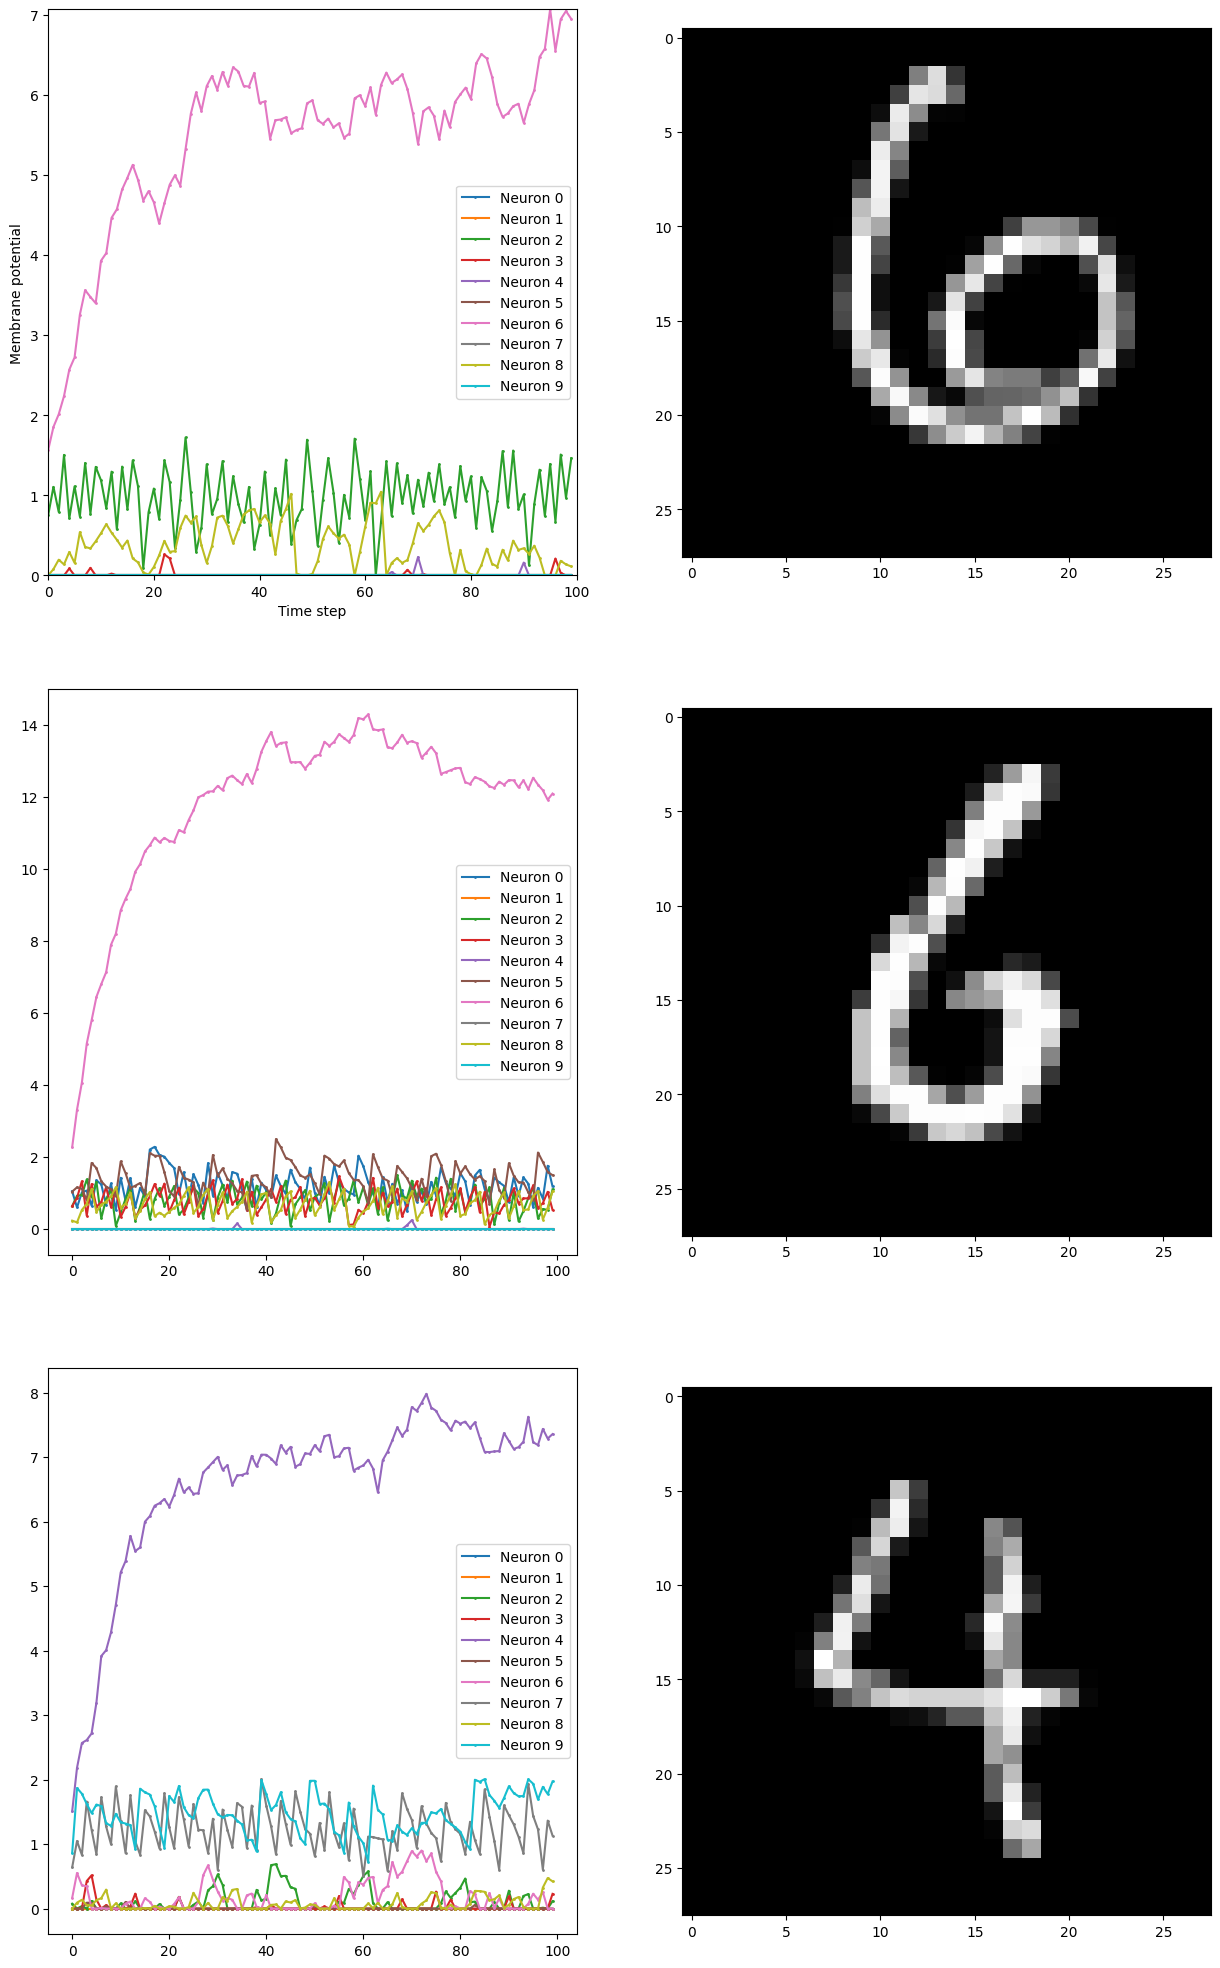

In [27]:
# get V_mem_data for one test image
img_b_test, lbl_b_test = next(iter(test_loader_unencoded))

img_b_test_e, lbl_b_test_e = next(iter(test_loader))

id1 = 100
id2 = 50
id3 = 24

V_mem_data1 = V_mem_from_img_id(id1)
V_mem_data2 = V_mem_from_img_id(id2)
V_mem_data3 = V_mem_from_img_id(id3)

test_img1 = img_b_test[id1]
test_img2 = img_b_test[id2]
test_img3 = img_b_test[id3]

# for all V_mem_data, plot the 10 diferent membrane potentials in a single plot and next to it plot the corresponding input image
fig, ax = plt.subplots(3, 2, figsize=(1500*px, 2500*px))
xs = jnp.arange(100)
y_max = V_mem_data1.max(axis=0).max(axis=0) if V_mem_data1.max(axis=0).max(axis=0) > 1.0 else 1.0
for i in range(10):
    ax[0, 0].plot(xs, V_mem_data1[:, i], label=f'Neuron {i}', marker='o', markersize=1)
    ax[1, 0].plot(xs, V_mem_data2[:, i], label=f'Neuron {i}', marker='o', markersize=1)
    ax[2, 0].plot(xs, V_mem_data3[:, i], label=f'Neuron {i}', marker='o', markersize=1)
ax[0, 0].set_xlabel('Time step')
ax[0, 0].set_ylabel('Membrane potential')
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylim(0, y_max)
# legend for every plot
ax[0, 0].legend()
ax[1, 0].legend()
ax[2, 0].legend()
ax[0, 1].imshow(test_img1.reshape(28,28), cmap='gray')
ax[1, 1].imshow(test_img2.reshape(28,28), cmap='gray')
ax[2, 1].imshow(test_img3.reshape(28,28), cmap='gray')
plt.show()